<a href="https://colab.research.google.com/github/yejoonlee/TSA_Projects/blob/main/TSA_practice/2_check_features_visually.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 해당 파일은 데이터의 feature들을 파악하고 타겟 데이터와의 관계성을 시각적으로 확인하는 방법의 예시를 보여준다.


### **0. load data & feature engineering**

In [ ]:
!python -m pip install --user --upgrade pip

     |████████████████████████████████| 1.7 MB 11.2 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy the path to data and read by pandas
location = '/content/drive/MyDrive/Colab Notebooks/practice/TSA_Practice/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


In [ ]:
### Feature engineering of all
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe
    
raw_fe = feature_engineering(raw_all)

In [ ]:
raw_fe.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,"17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00",...,"17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00","17,544.00"
mean,2.50,0.03,0.68,1.43,20.30,23.71,62.87,12.81,35.35,152.44,...,4.51,6.52,15.74,11.51,3.00,187.79,187.79,0.25,0.25,0.25
std,1.11,0.17,0.47,0.65,7.92,8.62,19.34,8.29,49.19,151.28,...,2.29,3.45,8.80,6.94,2.01,181.35,181.35,0.43,0.43,0.43
min,1.00,0.00,0.00,1.00,0.82,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,48.00,7.00,4.00,32.00,...,3.00,4.00,8.00,5.00,1.00,38.00,38.00,0.00,0.00,0.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,63.00,13.00,16.00,114.00,...,5.00,7.00,16.00,12.00,3.00,140.00,140.00,0.00,0.00,0.00
75%,3.00,0.00,1.00,2.00,27.06,31.06,79.00,17.00,48.00,219.00,...,7.00,10.00,23.00,17.25,5.00,279.00,279.00,0.00,1.00,1.00
max,4.00,1.00,1.00,4.00,41.00,50.00,100.00,57.00,367.00,886.00,...,8.00,12.00,31.00,23.00,6.00,977.00,977.00,1.00,1.00,1.00


## **1. feature들의 분포 및 타겟 데이터와의 관계를 시각적으로 확인하는 예시**


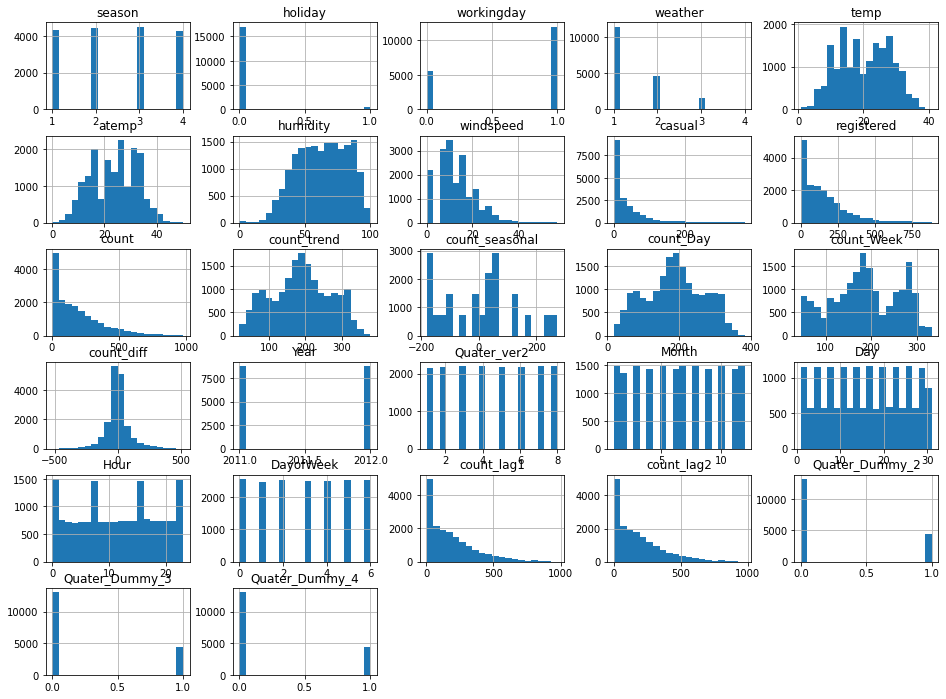

In [ ]:
# 히스토그램으로 그려 모든 feature들의 분포를 시각적으로 확인
raw_fe.hist(bins=20, grid=True, figsize=(16,12))
plt.show()

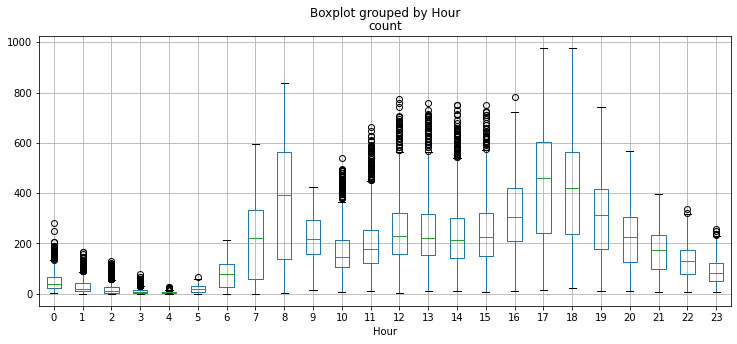

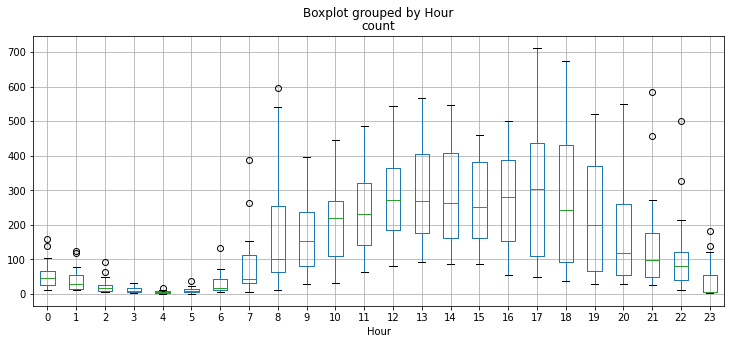

In [ ]:
# box plot example
# holiday가 0인 데이터와 1인 데이터를 따로 분류하여 Hour마다 count를 box plot으로 시각화 예제
# box plot은 중앙값과 사분위수를 박스 형태로 보여주어 시각적으로 간단하게 비교할 수 있다.
# 아래 결과를 간단히 비교해보자면 holiday인 데이터가 10시부터 15시까지 count 중앙값 및 사분위수가 급증하여 차이가 나는 것을 확인할 수 있다.
raw_fe[raw_fe.holiday == 0].boxplot(column='count', by='Hour', grid=True, figsize=(12,5))
plt.show()
raw_fe[raw_fe.holiday == 1].boxplot(column='count', by='Hour', grid=True, figsize=(12,5))
plt.show()

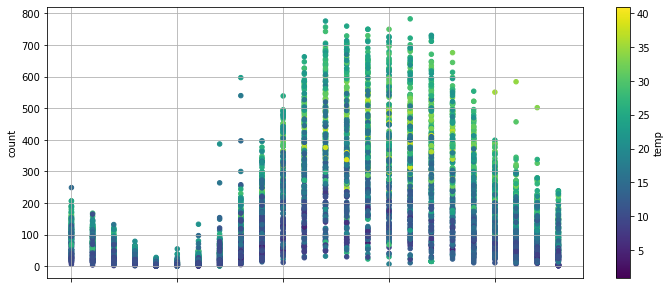

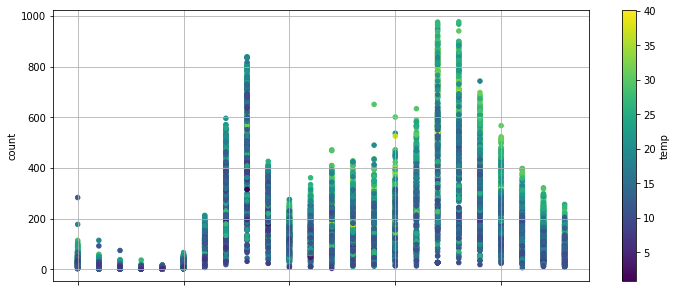

In [ ]:
# scatter plot for some group
# workingday가 0인 데이터와 1인 데이터를 따로 분류하여 Hour마다 count와 temp를 색상으로 구분되는 scatter plot으로 시각화 예제
# box plot과 다르게 3가지 feature를 한 plot에 시각화 할 수 있으며 실제 각 데이터들을 직접 보는 효과를 볼 수 있다.
# 아래 결과를 간단히 비교해보자면 위의 결과와 같이 workingday가 아닌 데이터가 10시부터 15시까지 count 분포가 더 높은 것으로 확인되고
# count가 낮은 데이터는 대체로 색이 어두운 temp가 낮은 데이터이고 count가 높은 데이터는 대체로 색이 밝은 temp가 높은 데이터로 확인된다.
raw_fe[raw_fe.workingday == 0].plot.scatter(y='count', x='Hour', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()
raw_fe[raw_fe.workingday == 1].plot.scatter(y='count', x='Hour', c='temp', grid=True, figsize=(12,5), colormap='viridis')
plt.show()

In [ ]:
# generate cross table
# plot이 아닌 table 형태로는 pd.crosstab을 활용하여 cross table을 그려볼 수 있다.
sub_table = pd.crosstab(index=raw_fe['count'], columns=raw_fe['weather'], margins=True)
sub_table/sub_table.loc['All']*100

weather,1,2,3,4,All
count,,,,,
1,0.87,0.99,1.77,0.00,0.98
2,1.19,1.29,2.43,0.00,1.32
3,1.19,1.45,2.69,0.00,1.39
4,1.30,1.36,2.36,0.00,1.41
5,1.43,1.38,2.36,0.00,1.50
...,...,...,...,...,...
968,0.01,0.00,0.00,0.00,0.01
970,0.01,0.00,0.00,0.00,0.01
976,0.01,0.00,0.00,0.00,0.01


In [ ]:
# groupby를 통해 2개의 feature만이 아닌 다른 feature들도 비교하는 cross table을 만들 수 있으며 그룹지어진 테이블 안의 값은 count, mean 또는 agg로 aggregate되어 활용할 수 있다
display(raw_fe.groupby(['weather', 'DayofWeek']).count())
display(raw_fe.groupby(['weather', 'DayofWeek']).mean())
raw_fe.groupby(['weather', 'DayofWeek']).agg({'count':[sum, min, max]})

datetime  season  holiday  workingday  temp  atemp  \
weather DayofWeek                                                       
1       0              1594    1594     1594        1594  1594   1594   
        1              1527    1527     1527        1527  1527   1527   
        2              1577    1577     1577        1577  1577   1577   
        3              1660    1660     1660        1660  1660   1660   
        4              1649    1649     1649        1649  1649   1649   
...                     ...     ...      ...         ...   ...    ...   
3       5               201     201      201         201   201    201   
        6               170     170      170         170   170    170   
4       0                 1       1        1           1     1      1   
        2                 1       1        1           1     1      1   
        5                 1       1        1           1     1      1   

                   humidity  windspeed  casual  registered  ...  Year  \
weather DayofWeek                                           ...         
1       0              1594       1594    1594        1594  ...  1594   
        1              1527       1527    1527        1527  ...  1527   
        2              1577       1577    1577        1577  ...  1577   
        3              1660       1660    1660        1660  ...  1660   
        4              1649       1649    1649        1649  ...  1649   
...                     ...        ...     ...         ...  ...   ...   
3       5               201        201     201         201  ...   201   
        6               170        170     170         170  ...   170   
4       0                 1          1       1           1  ...     1   
        2                 1          1       1           1  ...     1   
        5                 1          1       1           1  ...     1   

                   Quater_ver2  Month   Day  Hour  count_lag1  count_lag2  \
weather DayofWeek                                                           
1       0                 1594   1594  1594  1594        1594        1594   
        1                 1527   1527  1527  1527        1527        1527   
        2                 1577   1577  1577  1577        1577        1577   
        3                 1660   1660  1660  1660        1660        1660   
        4                 1649   1649  1649  1649        1649        1649   
...                        ...    ...   ...   ...         ...         ...   
3       5                  201    201   201   201         201         201   
        6                  170    170   170   170         170         170   
4       0                    1      1     1     1           1           1   
        2                    1      1     1     1           1           1   
        5                    1      1     1     1           1           1   

                   Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
weather DayofWeek                                                  
1       0                    1594            1594            1594  
        1                    1527            1527            1527  
        2                    1577            1577            1577  
        3                    1660            1660            1660  
        4                    1649            1649            1649  
...                           ...             ...             ...  
3       5                     201             201             201  
        6                     170             170             170  
4       0                       1               1               1  
        2                       1               1               1  
        5                       1               1               1  

[24 rows x 27 columns]

season  holiday  workingday  temp  atemp  humidity  \
weather DayofWeek                                                       
1       0            2.45     0.14        0.86 20.70  24.23     59.05   
        1            2.48     0.00        1.00 21.36  24.89     57.11   
        2            2.50     0.01        0.99 21.61  25.08     58.23   
        3            2.53     0.03        0.97 21.35  24.88     55.85   
        4            2.56     0.03        0.97 20.71  24.00     57.06   
...                   ...      ...         ...   ...    ...       ...   
3       5            2.31     0.00        0.00 17.50  20.48     86.43   
        6            2.62     0.00        0.00 19.17  22.40     81.39   
4       0            1.00     0.00        1.00  8.20  11.37     86.00   
        2            1.00     0.00        1.00  9.02   9.85     93.00   
        5            1.00     0.00        0.00  5.74   6.82     86.00   

                   windspeed  casual  registered  count  ...     Year  \
weather DayofWeek                                        ...            
1       0              12.86   30.40      160.04 190.43  ... 2,011.49   
        1              12.95   27.57      186.58 214.14  ... 2,011.51   
        2              12.22   26.65      181.52 208.17  ... 2,011.53   
        3              13.01   28.95      184.81 213.77  ... 2,011.54   
        4              12.73   33.50      168.64 202.14  ... 2,011.49   
...                      ...     ...         ...    ...  ...      ...   
3       5              18.08   26.43       70.57  97.00  ... 2,011.46   
        6              16.12   31.76       84.02 115.78  ... 2,011.58   
4       0               6.00    6.00      158.00 164.00  ... 2,012.00   
        2              22.00    1.00       35.00  36.00  ... 2,011.00   
        5              13.00    1.00       22.00  23.00  ... 2,012.00   

                   Quater_ver2  Month   Day  Hour  count_lag1  count_lag2  \
weather DayofWeek                                                           
1       0                 4.42   6.36 15.64 11.39      188.77      188.68   
        1                 4.48   6.22 16.16 12.17      213.34      213.59   
        2                 4.59   6.41 15.86 11.60      207.08      209.14   
        3                 4.64   6.51 15.01 11.90      213.36      214.26   
        4                 4.52   6.71 15.41 11.57      203.38      204.10   
...                        ...    ...   ...   ...         ...         ...   
3       5                 4.15   5.71 16.32 12.18      109.89      120.54   
        6                 4.87   6.46 14.36 13.77      143.89      166.62   
4       0                 5.00   1.00  9.00 18.00      152.00       49.00   
        2                 1.00   1.00 26.00 16.00       43.00       36.00   
        5                 5.00   1.00 21.00  1.00       24.00       38.00   

                   Quater_Dummy_2  Quater_Dummy_3  Quater_Dummy_4  
weather DayofWeek                                                  
1       0                    0.25            0.27            0.22  
        1                    0.24            0.30            0.20  
        2                    0.27            0.30            0.20  
        3                    0.28            0.28            0.22  
        4                    0.28            0.25            0.26  
...                           ...             ...             ...  
3       5                    0.21            0.30            0.17  
        6                    0.25            0.28            0.25  
4       0                    0.00            0.00            0.00  
        2                    0.00            0.00            0.00  
        5                    0.00            0.00            0.00  

[24 rows x 25 columns]

count          
                      sum  min  max
weather DayofWeek                  
1       0          303551    1  968
        1          326993    1  970
        2          328285    1  977
        3          354852    1  976
        4          333333    1  900
...                   ...  ...  ...
3       5           19498    1  584
        6           19683    1  626
4       0             164  164  164
        2              36   36   36
        5              23   23   23

[24 rows x 3 columns]

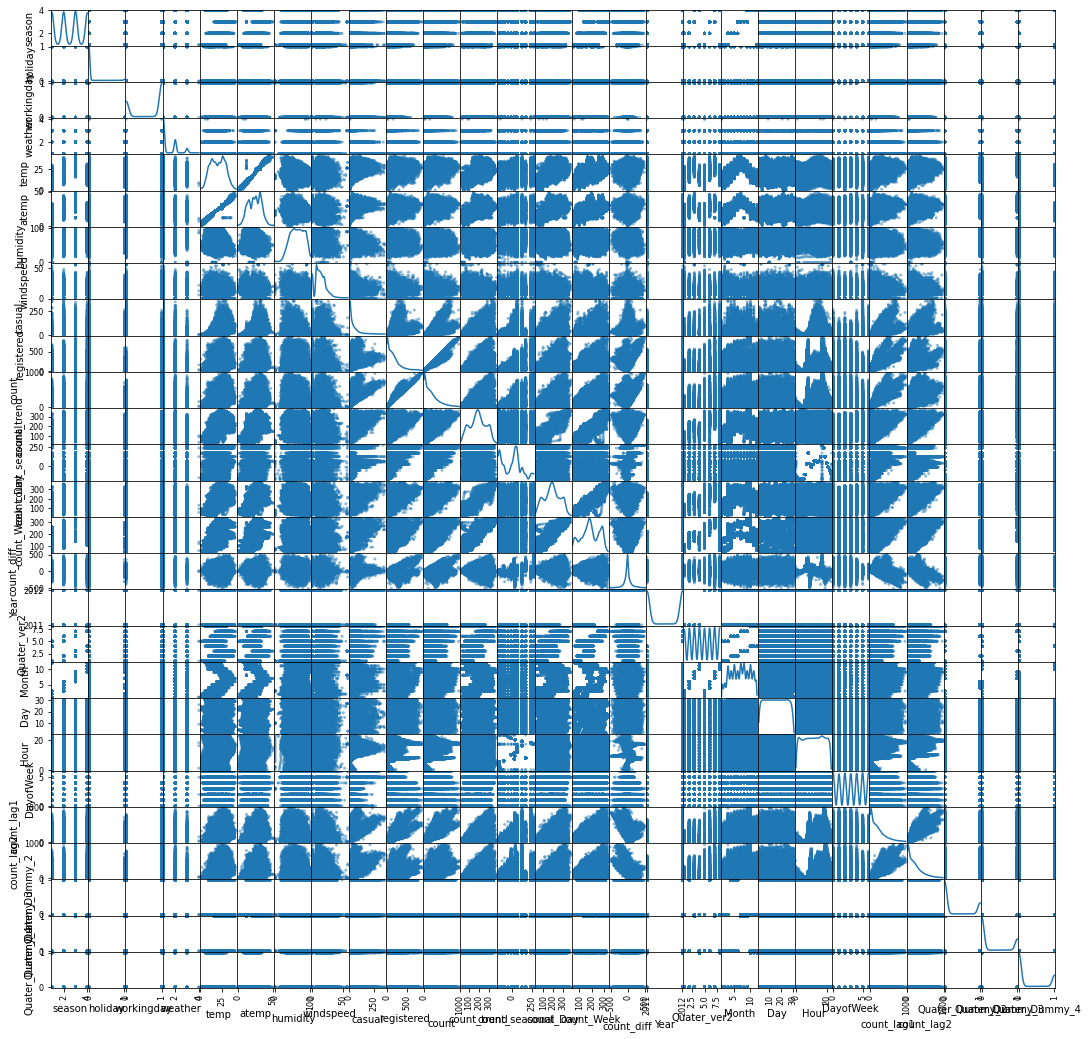

In [ ]:
# scatter_matrix를 활용하면 실행이 오래 걸리지만 모든 feature들의 관계를 scatter plot으로 그린 plot들을 한번에 볼 수 있다.
pd.plotting.scatter_matrix(raw_fe, figsize=(18,18), diagonal='kde')
plt.show()

In [ ]:
# correlation example
# correlation을 그래프의 형태로 추측하는 것이 아니라 수치로 table에 들어있는 값을 통해 확인할 수 있다.
raw_fe.corr().style.background_gradient().set_precision(2).set_properties(**{'font-size': '15pt'})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_Day,count_Week,count_diff,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
season,1.00,-0.02,0.02,-0.02,0.32,0.33,0.15,-0.14,0.12,0.18,0.18,0.41,0.00,0.41,0.47,-0.00,-0.00,0.42,0.83,-0.00,-0.01,-0.01,0.18,0.18,-0.20,0.31,0.60
holiday,-0.02,1.00,-0.26,-0.00,-0.04,-0.04,-0.01,0.01,0.03,-0.05,-0.04,-0.08,-0.00,-0.07,-0.04,-0.00,0.00,0.01,0.01,-0.01,0.01,-0.19,-0.04,-0.04,-0.03,-0.03,0.05
workingday,0.02,-0.26,1.00,0.04,0.05,0.05,0.02,-0.02,-0.30,0.13,0.03,0.04,0.00,0.02,0.02,0.01,0.00,-0.00,-0.00,0.01,-0.00,-0.70,0.03,0.02,0.01,0.01,-0.02
weather,-0.02,-0.00,0.04,1.00,-0.11,-0.11,0.43,0.05,-0.16,-0.13,-0.15,-0.25,-0.00,-0.17,-0.07,-0.02,-0.02,-0.02,0.00,0.01,-0.02,-0.06,-0.14,-0.14,-0.03,-0.07,0.05
temp,0.32,-0.04,0.05,-0.11,1.00,0.99,-0.07,-0.02,0.46,0.34,0.41,0.60,0.17,0.61,0.62,-0.00,0.05,0.14,0.21,0.02,0.14,-0.03,0.41,0.40,0.26,0.60,-0.31
atemp,0.33,-0.04,0.05,-0.11,0.99,1.00,-0.06,-0.06,0.46,0.34,0.41,0.61,0.16,0.61,0.62,-0.01,0.05,0.15,0.22,0.02,0.13,-0.03,0.41,0.40,0.27,0.58,-0.29
humidity,0.15,-0.01,0.02,0.43,-0.07,-0.06,1.00,-0.27,-0.35,-0.28,-0.33,-0.09,-0.34,-0.06,0.04,0.00,-0.08,0.00,0.16,0.03,-0.27,-0.04,-0.33,-0.31,-0.03,0.06,0.10
windspeed,-0.14,0.01,-0.02,0.05,-0.02,-0.06,-0.27,1.00,0.08,0.07,0.08,-0.16,0.19,-0.14,-0.10,0.01,-0.01,-0.07,-0.13,0.02,0.14,-0.00,0.08,0.06,0.04,-0.10,-0.06
casual,0.12,0.03,-0.30,-0.16,0.46,0.46,-0.35,0.08,1.00,0.51,0.70,0.39,0.44,0.39,0.34,0.08,0.14,0.16,0.07,-0.01,0.30,0.24,0.65,0.58,0.15,0.17,-0.10
registered,0.18,-0.05,0.13,-0.13,0.34,0.34,-0.28,0.07,0.51,1.00,0.97,0.40,0.71,0.38,0.36,0.31,0.26,0.28,0.13,-0.01,0.37,-0.08,0.80,0.53,0.06,0.13,-0.00
